# 1. Nested cross-validation exercise
## Nested cross-validation for feature selection with nearest neighbors <br>
- Use Python 3 to program both a hyper-parameter selection method based on leave-one-out cross-validation and a nested leave-one-out cross-validation for estimating the prediction performance of models inferred with this automatic selection approach. Use base learning algorithm provided in the exercise, namely the "use_ith_feature" method, so that the value of the hyper-parameter i is automatically selected from the range from 1 to 100 of alternative values. The provided base learning algorithm "use_ith_feature" is 1-nearest neighbor that uses only the ith feature of the data given to it. The LOOCV based hyper-parameter selection procedure is supposed to select the best feature, e.g. the value of i, based on C-index evaluated with predictions obtained with leave-one-out cross-validation. A ready-made implementation of C-index is also provided in the exercise. In nested leave-one-out cross-validation, a C_index value is further evaluated on the predictions obtained from an outer leave-one-out cross-validation. During each round of this outer LOOCV, the whole feature selection process based on inner LOOCV is separately done and the selected feature is used for prediction for the test data point held out during that round of the outer LOOCV. Accordingly, the actual learning algorithm, whose prediction performance will be evaluated with nested CV, is the one that automatically selects the single best feature with leave-one-out cross-validation based model selection (see the lectures and the pseudo codes presented on them for more info on this interpretation).
- Note that since the hold-out set in LOOCV has only a single datum but C-index requires at least two data points. The solution in this exercise is to "pool" the predictions of all LOOCV rounds of a single LOOCV computation into an array of length of the data used in that LOOCV computation and then compute C-index on that array and the corresponding true outputs. This pooling approach, however, does have its weaknesses, since C-index computed from pooled LOOCV outputs may sometimes be a heavily biased estimator of the true C-index. This has been considered in detail in our previous research (and other group's too as seen in the references) that is available here:
http://dx.doi.org/10.1177/0962280218795190
where AUC, a special case of C-index, is considered. The study goes quite deep into the problem of AUC estimation with CV, and you can read it if you are interested about the research carried out in our laboratory, while EMLM course does not go that far and this year's exercise unfortunately still has this non-optimal pooling approach in use.
- Compare the C-index produced by nested leave-one-out CV with the result of ordinary leave-one-out CV with the best value of i e.g. the feature providing the highest LOOCV C-index, and show the C-index difference between the two methods.
- Use the provided implementation of the "use_ith_feature" learning algorithm and C-index functions in your exercise.

As a summary, for completing this exercise implement the following steps: 
_______________________________________________________________
#### 1. Use leave-one-out cross-validation for determining the optimal i-parameter for the data (X_alternative.csv, y_alternative.csv) from the set of possible values of i e.g. {1,...,100}. When you have found the optimal i, save the corresponding C-index (call it *loo_c_index*) for this parameter.
#### 2. Similarly, use nested leave-one-out cross-validation (leave-one-out both in outer and inner folds) for estimating the C-index (call it *nloo_c_index*) of the method that selects the best feature with leave-one-out approach. 
#### 3. Return both this notebook and as a PDF-file made from it in the exercise submit page. 
_______________________________________________________________

Remember to use the provided learning algorithm use_ith_feature and C-index functions in your implementation! 

## Import libraries

In [1]:
#In this cell import all libraries you need. For example: 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Provided functions 

In [2]:
"""
C-index function: 
- INPUTS: 
'y' an array of the true output values
'yp' an array of predicted output values
- OUTPUT: 
The c-index value
"""
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n

"""
Self-contained 1-nearest neighbor using only a single feature
- INPUTS: 
'X_train' a numpy matrix of the X-features of the train data points
'y_train' a numpy matrix of the output values of the train data points
'X_test' a numpy matrix of the X-features of the test data points
'i' the index of the feature to be used with 1-nearest neighbor
- OUTPUT: 
'y_predictions' a list of the output value predictions
"""
def use_ith_feature(X_train, y_train, X_test, i):
    y_predictions = []
    for test_ind in range(0, X_test.shape[0]):
        diff = X_test[test_ind, i] - X_train[:, i]
        distances = np.sqrt(diff * diff)
        sort_inds = np.array(np.argsort(distances), dtype=int)
        y_predictions.append(y_train[sort_inds[0]])
    return y_predictions


## Your implementation here

In [60]:
# load data

x_data = np.loadtxt('X_alternative.csv', delimiter=",")
y_data = np.loadtxt('y_alternative.csv', delimiter=",")

print(f'x_data : {x_data.shape}\ny_data : {y_data.shape}')  # N = 30

x_data : (30, 100)
y_data : (30,)


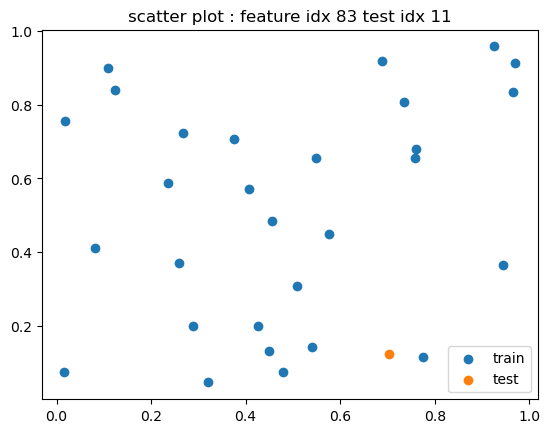

In [5]:
# visualization pair data

random_feature_idx = np.random.choice(x_data.shape[1])
random_test_idx = np.random.choice(x_data.shape[0])

x_test = x_data[random_test_idx, random_feature_idx]
y_test = y_data[random_test_idx]

x_train = np.delete(x_data, random_test_idx, axis=0)
y_train = np.delete(y_data, random_test_idx, axis=0)

plt.figure()
#plt.scatter(x_data[:, random_feature_idx], y_data)
plt.scatter(x_train[:, random_feature_idx], y_train)
plt.scatter(x_test, y_test)
plt.title(f"scatter plot : feature idx {random_feature_idx} test idx {random_test_idx}")
plt.legend(['train', 'test'])
plt.show()

In [86]:
# running leave-one-out cross-validation for features selection(inner loop)
def feature_selector(x_data, y_data):
    """select best feature from 1-nearest neighbor
    INPUT:
        'x_data' - 2-dimension x points with features 
        'y_data' - 1-dimension coresponding y points
    OUTPUT:
        'best_feature' - the number of best feature
        'looc_indx' - the c-index of best feature
    """
    best_feature, looc_indx = 0, 0
    for feature_idx in range(0, x_data.shape[1]):
        
        x_select_feature = x_data[:, feature_idx]
        y_prediction = []
        for test_idx in range(x_select_feature.shape[0]):
            x_test = x_select_feature[test_idx]
            y_test = y_data[test_idx]
            x_train = np.delete(x_select_feature, test_idx)
            y_train = np.delete(y_data, test_idx)    
            diffs = x_test - x_train
            distances = np.sqrt(diffs * diffs)
            sort_indx = np.argmin(distances)
            y_prediction.append(y_train[sort_indx])
            
        cindx = cindex(y_data, y_prediction)
        if cindx > looc_indx:
            best_feature, looc_indx = feature_idx, cindx
    
    return best_feature, looc_indx
        
        
best_feature, looc_indx = feature_selector(x_data, y_data)
print(f'the best feature is {best_feature}, coresponding with c-index {looc_indx}')

the best feature is 76, coresponding with c-index 0.6620689655172414


In [50]:
# running nested loocv for estimate c-index provide by inner loop







(30, 99)
